In [8]:
import pandas as pd
import numpy as np

import sqlite3
import json
import base64
import bitstring

import time
import datetime
from astral import Astral
from astral import  AstralGeocoder
from astral import  Location


import mpld3
import matplotlib.pyplot as plt

# 1. Import data

In [9]:
#dbPath='/home/vologa/DEV/health/miband_analytics_father/apps/com.xiaomi.hm.health/db/origin_db_1588100489'
dbPath='/home/vologa/DEV/health/miband_analytics/db/origin_db_1582177486'

In [10]:
con = sqlite3.connect(dbPath)
df = pd.read_sql_query("SELECT * from DATE_DATA", con)

In [11]:
df.tail()

,TYPE,SOURCE,DATE,SUMMARY,INDEXS,DATA,DATA_HR,SUMMARY_HR,SYNC,SYNC_QQHEALTH,TIME_ZONE,DEVICE_ID
365,0,0,2016-06-08,"{""v"":5,""slp"":{""st"":1465345260,""ed"":1465366740,...",None,"[{""start"":0,""stop"":1439,""value"":""AAoAEBgAAB8AA...",None,None,1,0,12,887EF69B00000285
366,0,0,2016-06-11,"{""v"":5,""slp"":{""st"":1465591680,""ed"":1465628520,...",None,"[{""start"":0,""stop"":1439,""value"":""AAAAEAAAAAAAB...",None,None,1,0,12,887EF69B00000285
367,0,0,2016-06-10,"{""v"":5,""slp"":{""st"":1465512840,""ed"":1465537920,...",None,"[{""start"":0,""stop"":1439,""value"":""ABsAEC8AAB0AA...",None,None,1,0,12,887EF69B00000285
368,0,0,2016-06-07,"{""v"":5,""slp"":{""st"":1465251660,""ed"":1465276020,...",None,"[{""start"":0,""stop"":1439,""value"":""ADIAEEYAABoAA...",None,None,1,0,12,887EF69B00000285
369,0,0,2016-06-12,"{""v"":5,""slp"":{""st"":1465684560,""ed"":1465710300,...",None,"[{""start"":0,""stop"":1439,""value"":""ABgAEAUAABQAA...",None,None,1,NaN,12,887EF69B00000285


## 1.1 Extract summary

In [12]:
#old format
#u'{"slp":{"usrEd":-1440,"lt":447,"st":1464723180,"wk":0,"dp":10,"usrSt":-1440,"ed":1464750600},
#"v":5,"goal":8000,
#"stp":{"rn":0,"cal":237,"runDist":0,"wk":61,"ttl":5071,"runCal":0,"dis":4050}}'

#new format
#u'{"slp":{"lt":0,"st":1441400400,"wk":0,"dp":0,"ed":1441400400},
#"v":5,"goal":8000,
#"stp":{"rn":0,"cal":30,"runDist":6,"wk":13,"ttl":619,"runCal":0,"dis":428}}'

def extractSummary(summaryJson):
    s=json.loads(summaryJson)
    return \
    s['slp']['usrEd'] if "usrEd" in s['slp'] else None, \
    s['slp']['lt'], \
    s['slp']['st'], \
    time.strftime("%H:%M", time.localtime(int(s['slp']['st']))), \
    s['slp']['wk'], \
    s['slp']['dp'], \
    s['slp']['usrSt'] if "usrSt" in s['slp'] else None,  \
    s['slp']['ed'], \
    time.strftime("%H:%M", time.localtime(int(s['slp']['ed']))), \
    s['v'], \
    s['goal'], \
    s['stp']['rn'], \
    s['stp']['cal'], \
    s['stp']['runDist'], \
    s['stp']['wk'], \
    s['stp']['ttl'], \
    s['stp']['runCal'], \
    s['stp']['dis'], \
    


In [13]:
   dfS = pd.DataFrame();

In [14]:
    dfS['s_usrEd'],\
    dfS['s_lt'], \
    dfS['s_st'], \
    dfS['s_st_t'], \
    dfS['s_wk'], \
    dfS['s_deep'], \
    dfS['s_usrSt'], \
    dfS['s_ed'], \
    dfS['s_ed_t'], \
    dfS['v'], \
    dfS['goal'], \
    dfS['a_rn'], \
    dfS['a_cal'], \
    dfS['a_runDist'], \
    dfS['a_wk'], \
    dfS['a_ttl'], \
    dfS['a_runCal'], \
    dfS['a_dis'], \
=zip(*df['SUMMARY'].map(extractSummary))

In [15]:
dfS['DATE'] = df['DATE']

In [16]:
# s_lt - all sleep time (min)
# s_st - sleep begin time 


dfS.tail()

,s_usrEd,s_lt,s_st,s_st_t,s_wk,s_deep,s_usrSt,s_ed,s_ed_t,v,goal,a_rn,a_cal,a_runDist,a_wk,a_ttl,a_runCal,a_dis,DATE
365,-1440,307,1465345260,03:21,0,51,-1440,1465366740,09:19,5,8000,3,333,404,71,5485,24,3968,2016-06-08
366,-1440,519,1465591680,23:48,1,94,-1440,1465628520,10:02,5,8000,2,555,204,133,9785,12,6813,2016-06-11
367,-1440,362,1465512840,01:54,0,56,-1440,1465537920,08:52,5,8000,5,531,531,111,9131,30,6460,2016-06-10
368,-1440,339,1465251660,01:21,0,67,-1440,1465276020,08:07,5,8000,2,364,202,80,6258,12,4462,2016-06-07
369,-1440,394,1465684560,01:36,0,35,-1440,1465710300,08:45,5,8000,2,508,214,103,7911,13,5522,2016-06-12


## 1.1.2 Add extra columns

### 1.1.2.1 Add timestamp column

In [17]:
def convertToTimestamp(date):
    return int(time.mktime(datetime.datetime.strptime(date, "%Y-%m-%d").timetuple()));

In [18]:
dfS['date_timestamp'] = dfS['DATE'].map(convertToTimestamp)

### 1.1.2.2 Convert sleep start time to minuts before midnight and wake up time to time after midnight

In [19]:
dfS['s_st_md']=(dfS['date_timestamp']-dfS['s_st'])/60
dfS['s_ed_md']=(dfS['date_timestamp']-dfS['s_ed'])/60

### 1.1.2.3 Add day of week

In [20]:
dfS['day'] = pd.to_datetime(dfS['DATE']).dt.dayofweek
dfS['week_number'] =  pd.to_datetime(dfS['DATE']).dt.week

### 1.1.2.4 And sunrise sunset time

In [21]:
l = Location()
l.name = 'Saint-Petersburg'
l.region = 'SPb'
l.latitude = 59.9343
l.longitude = 30.3351
l.timezone = 'Europe/Moscow'
l.elevation = 0
l.sun();

In [22]:
sun  = l.sun(date=datetime.datetime.fromtimestamp(1465333200), local=True)

In [23]:
def getSunRiseSet(l,ts):
    sun  = l.sun(date=datetime.datetime.fromtimestamp(ts), local=True);
    ss = (int(time.mktime(sun['sunset'].timetuple()))-(ts)-60*60*24)/60;
    sr = (int(time.mktime(sun['sunrise'].timetuple()))-ts)/60;
    return ss, sr;

In [24]:
getSsSrSPb = lambda x: getSunRiseSet(l,x)

In [25]:
getSunRiseSet(l,1465333200)

(-104, 219)

In [26]:
dfS['sunset'], dfS['sunrise'] = zip(*dfS['date_timestamp'].map(getSsSrSPb))

In [27]:
dfS.tail()

,s_usrEd,s_lt,s_st,s_st_t,s_wk,s_deep,s_usrSt,s_ed,s_ed_t,v,...,a_runCal,a_dis,DATE,date_timestamp,s_st_md,s_ed_md,day,week_number,sunset,sunrise
365,-1440,307,1465345260,03:21,0,51,-1440,1465366740,09:19,5,...,24,3968,2016-06-08,1465333200,-201,-559,2,23,-104,219
366,-1440,519,1465591680,23:48,1,94,-1440,1465628520,10:02,5,...,12,6813,2016-06-11,1465592400,12,-602,5,23,-101,217
367,-1440,362,1465512840,01:54,0,56,-1440,1465537920,08:52,5,...,30,6460,2016-06-10,1465506000,-114,-532,4,23,-102,217
368,-1440,339,1465251660,01:21,0,67,-1440,1465276020,08:07,5,...,12,4462,2016-06-07,1465246800,-81,-487,1,23,-105,220
369,-1440,394,1465684560,01:36,0,35,-1440,1465710300,08:45,5,...,13,5522,2016-06-12,1465678800,-96,-525,6,23,-100,216


## 1.2 Extract RAW

### 1.2.1  Extract atvitiy and sleep RAW data

In [28]:
#extract raw activity & sleep data
#u'[{"value":"BRQAFQAABQA ... ABQAA","did":"88EC252D04000427","stop":1439,"src":4,"tz":12,"start":0}]'

def extractRawData(rawData):
    if rawData:
        r=json.loads(rawData)
        value = r[0]['value']
        f = base64.b64decode(value)
        return [map(ord,x) for x in map(list,map(''.join, zip(*[iter(f)]*3)))]
    else:
        return [[None, None, None]]*1440;

### 1.2.2 Extract Heart Rate data

In [29]:
#DATA_HR BLOB
def extractRawDataHR(rawData):
    if rawData:
        return list(bytearray(rawData));
    else:
        return [None]*1440;

### 1.2.3 Create data frames from Basic and Heart rate RAW data

In [30]:
def getRawDataDF(rawData, rawDataHR, date):
    rawList = np.asarray(extractRawData(rawData));
    rawListHR = np.asarray(extractRawDataHR(rawDataHR));
    rawDate = np.asarray(range(int(time.mktime(datetime.datetime.strptime(date, "%Y-%m-%d").timetuple())),
                  int(time.mktime(datetime.datetime.strptime(date, "%Y-%m-%d").timetuple()))+60*60*24,60));
    return np.column_stack((np.column_stack((rawDate, rawList)), rawListHR));

### 1.2.4 Process and genrate result data

In [31]:
resArray = getRawDataDF(df.DATA[0],df.DATA_HR[0],df.DATE[0])
resArray.shape
for r in range(1,df.shape[0]):
    resArray = np.vstack((resArray, getRawDataDF(df.DATA[r],df.DATA_HR[r],df.DATE[r])))

### 1.2.5 Create RAW data with timestamp as index

In [32]:
dfRaw = pd.DataFrame(resArray, index=pd.to_datetime(resArray[:,0], unit='s').tz_localize('UTC').tz_convert('Europe/Moscow'), columns=['timestamp', 'activity1', 'activity2', 'activity3', 'pulse'])

In [33]:
dfRawRed = dfRaw.dropna(subset = ['activity1'])

In [34]:
dfRawRed.shape

(105120, 5)

In [35]:
dfRawRed.tail()

,timestamp,activity1,activity2,activity3,pulse
2016-06-12 23:55:00+03:00,1465764900,126,0,0,None
2016-06-12 23:56:00+03:00,1465764960,126,0,0,None
2016-06-12 23:57:00+03:00,1465765020,126,0,0,None
2016-06-12 23:58:00+03:00,1465765080,126,0,0,None
2016-06-12 23:59:00+03:00,1465765140,126,0,0,None


In [36]:
#relation between s_lt and other fields
#dfS['s_lt_calc'] = dfS['s_st_md'] - dfS['s_ed_md'] - dfS['s_deep']

## 2. Compare application data, summary data and RAW data

In [37]:
def getDayFrame(date,df):
    ts1 = int(time.mktime(datetime.datetime.strptime(date, "%Y-%m-%d").timetuple()));
    ts2 = ts1 + 60*60*24;
    return df[(df['timestamp'] >=  ts1) & (df['timestamp'] <= ts2)];

In [38]:
def getFrameByTS(ts1,ts2,df):
    return df[(df['timestamp'] >=  ts1) & (df['timestamp'] <= ts2)];

In [39]:
def getSumForDay(date, df):
    dayFrame = getDayFrame(date,df);
    return dayFrame['activity1'].sum(),dayFrame['activity2'].sum(),dayFrame['activity3'].sum();
    

In [40]:
dayFrame = getDayFrame('2016-06-06',dfRawRed);

### 2.1 Activity

<table>
<tr>
<td>
<img src="screenshots/Screenshot_2016-06-06-22-56-31.jpg"/>
</td>
<td>
<img src="screenshots/Screenshot_2016-06-06-22-55-41.jpg"/>
</td>
<td>
<img src="screenshots/Screenshot_2016-06-06-22-56-11.jpg"/>
</td>
<td>
<img src="screenshots/Screenshot_2016-06-06-22-56-22.jpg"/>
</td>
</tr>
</table>

###  Summary activity (steps) just sum of TTL data

In [41]:
#Get steps from RAW data
getSumForDay('2016-06-06',dfRawRed)

(2069, 51374, 8102)

### Activity plot - just TTL vs time

In [42]:
# Activity plot
fig = plt.figure()


ax = fig.add_subplot(111, axisbg='#EEEEEE')
ax1 = fig.add_subplot(111, axisbg='#EEEEEE')

ax.plot(dayFrame['activity3'].values, color='red')

#plt.show()
mpld3.display(fig)

## Sleep

<img src="screenshots/Screenshot_2016-06-06-22-56-45.jpg" />

## Sleep time - s_ed - s_st summary data

In [43]:
sleepSec = (dfS.loc[363]['s_ed']-dfS.loc[363]['s_st'])

In [44]:
 str(datetime.timedelta(seconds=sleepSec))

'5:41:00'

In [45]:
 str(datetime.timedelta(seconds=dfS.loc[363]['s_deep']))

'0:01:15'

In [46]:
 str(datetime.timedelta(seconds=dfS.loc[363]['s_lt']))

'0:04:26'

### RAW data and sleep

In [47]:
dfS.loc[363]

s_usrEd                -1440
s_lt                     266
s_st              1465160160
s_st_t                 23:56
s_wk                       0
s_deep                    75
s_usrSt                -1440
s_ed              1465180620
s_ed_t                 05:37
v                          5
goal                    8000
a_rn                       3
a_cal                    469
a_runDist                293
a_wk                     100
a_ttl                   8102
a_runCal                  17
a_dis                   5737
DATE              2016-06-06
date_timestamp    1465160400
s_st_md                    4
s_ed_md                 -337
day                        0
week_number               23
sunset                  -107
sunrise                  221
Name: 363, dtype: object

### Value 4 - light sleep? No

In [48]:
dayFrame[(dayFrame['activity1'] > 0) & (dayFrame['activity1'] <=4)]['timestamp'].count() # != s_lt

173

### Value 5 - deep sleep? No

In [49]:
dayFrame[(dayFrame['activity1'] == 5)]['timestamp'].count()

154

### < 100 sleep ? No

In [50]:
dayFrame[(dayFrame['activity1'] > 0) & (dayFrame['activity1'] <=100)]['timestamp'].count() # != s_lt

372

In [51]:
dfS.loc[363]['s_lt']+dfS.loc[363]['s_deep']

341

### Data between sleep start and wake up = sleep time? No

In [52]:
dayFrameTR = dayFrame[(dayFrame['timestamp']>=1465160160) & (dayFrame['timestamp']<=1465180620)]

In [53]:
dayFrameTR[(dayFrameTR['activity1'] > 0) & (dayFrameTR['activity1'] <=100)]['timestamp'].count()

210

### Sleep time diagramm

In [54]:
%matplotlib inline
# Histogram with modified axes/grid
fig = plt.figure()

ordSleep = ((dayFrame['activity1'] !=4) & (dayFrame['activity1'] !=4) & ((dayFrame['activity1'] > 0) & (dayFrame['activity1'] <100))).values

ax = fig.add_subplot(111, axisbg='#EEEEEE')
ax1 = fig.add_subplot(111, axisbg='#EEEEEE')
ax2 = fig.add_subplot(111, axisbg='#EEEEEE')
ax.grid(color='white', linestyle='solid')
ax1.grid(color='white', linestyle='solid')
ax2.grid(color='white', linestyle='solid')
ax.plot((dayFrame['activity1'] == 4).values, color='blue');
ax1.plot(ordSleep, color='green');
ax1.fill_between(range(0,dayFrame.shape[0]), ordSleep, color='green')


mpld3.display(fig)

### Sleep bytes (activity1) by hours

In [55]:
%matplotlib inline
# Histogram with modified axes/grid
fig = plt.figure()


m_hours=dayFrame.index.hour

plt.plot(m_hours,dayFrame['activity1'].values,'x', color='blue');
#plt.plot(m_hours, dayFrame['activity2'].values, color='green');
#ax1.fill_between(range(0,dayFrame.shape[0]), ordSleep, color='green')
plt.gcf().autofmt_xdate()

mpld3.display(fig)

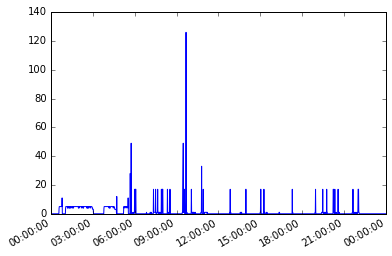

In [56]:
#mpld3.enable_notebook()
mpld3.disable_notebook()
dayFrame['activity1'].plot()

## 3. Analyze summary data

In [57]:
dfS.tail()

,s_usrEd,s_lt,s_st,s_st_t,s_wk,s_deep,s_usrSt,s_ed,s_ed_t,v,...,a_runCal,a_dis,DATE,date_timestamp,s_st_md,s_ed_md,day,week_number,sunset,sunrise
365,-1440,307,1465345260,03:21,0,51,-1440,1465366740,09:19,5,...,24,3968,2016-06-08,1465333200,-201,-559,2,23,-104,219
366,-1440,519,1465591680,23:48,1,94,-1440,1465628520,10:02,5,...,12,6813,2016-06-11,1465592400,12,-602,5,23,-101,217
367,-1440,362,1465512840,01:54,0,56,-1440,1465537920,08:52,5,...,30,6460,2016-06-10,1465506000,-114,-532,4,23,-102,217
368,-1440,339,1465251660,01:21,0,67,-1440,1465276020,08:07,5,...,12,4462,2016-06-07,1465246800,-81,-487,1,23,-105,220
369,-1440,394,1465684560,01:36,0,35,-1440,1465710300,08:45,5,...,13,5522,2016-06-12,1465678800,-96,-525,6,23,-100,216


## 3.1 Check simple dependencies

## Activity vs sleep

In [58]:
%matplotlib inline
mpld3.enable_notebook()

 * **Activity vs all sleep**

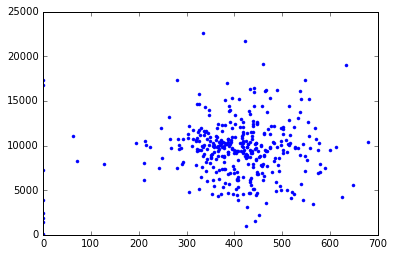

In [59]:
plt.plot((dfS['s_deep']+dfS['s_lt']).values, dfS['a_ttl'].values, '.')

* **Activity vs deep sleep**

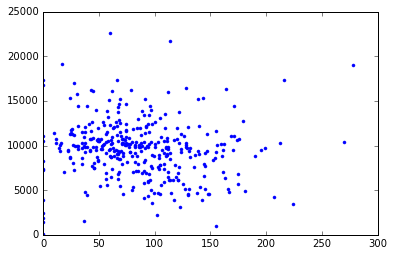

In [60]:
plt.plot(dfS['s_deep'].values, dfS['a_ttl'].values, '.')

## Sleep vs activity

In [61]:
ttlShifted = np.append(np.delete(dfS['a_ttl'].values,0),0)

 * **Deep sleep vs activity**

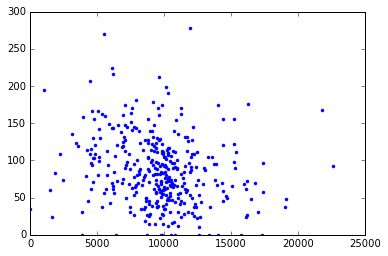

In [62]:
plt.plot(ttlShifted, dfS['s_deep'].values, '.')

 * **All sleep vs activity**

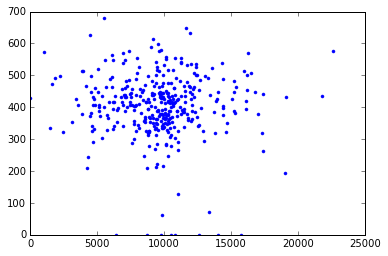

In [63]:
plt.plot(ttlShifted, (dfS['s_deep']+dfS['s_lt']).values, '.')

## Sleep ratio vs activity before

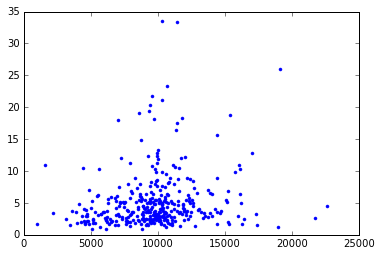

In [64]:
plt.plot(dfS['a_ttl'].values, (dfS['s_lt']/dfS['s_deep']).values, '.')

## Sleep ratio vs activity after

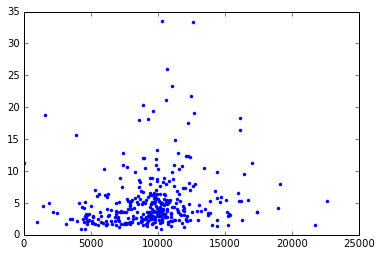

In [65]:
plt.plot(ttlShifted, (dfS['s_lt']/dfS['s_deep']).values, '.')

## Deep sleep vs sleep begin time (until midnight)

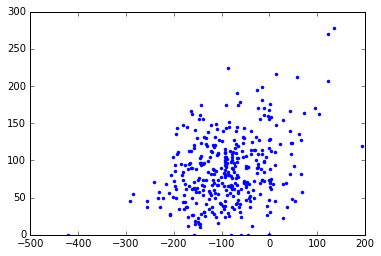

In [66]:
plt.plot(dfS['s_st_md'].values, dfS['s_deep'].values, '.')

## Sleep ratio vs sleep begin time (until midnight)

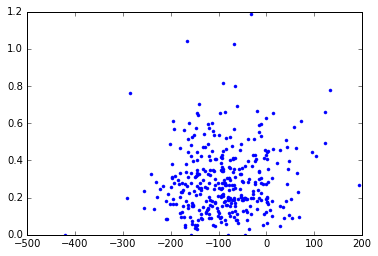

In [67]:
plt.plot(dfS['s_st_md'].values, (dfS['s_deep']/dfS['s_lt']).values, '.')

### Deep sleep vs light sleep

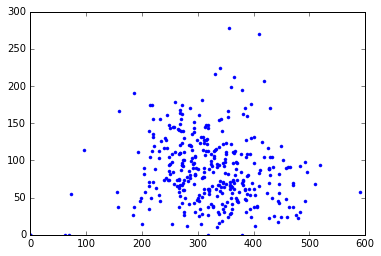

In [68]:
plt.plot(dfS['s_lt'].values, dfS['s_deep'].values, '.')

### Activity on wake up time

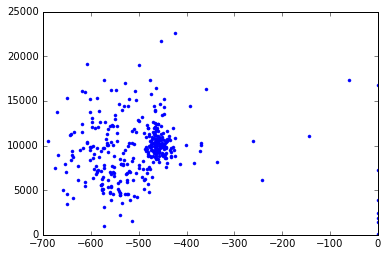

In [69]:
plt.plot(dfS['s_ed_md'].values, dfS['a_ttl'].values, '.')

### Sleep ratio vs activity

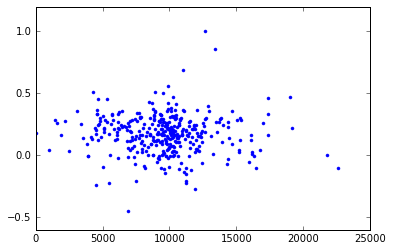

In [70]:
plt.plot(ttlShifted, (dfS['s_st_md']/dfS['s_ed_md']).values, '.')

### Sleep begin time vs sunset time

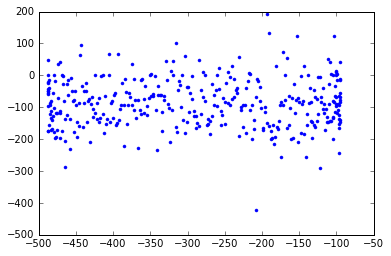

In [71]:
plt.plot(dfS['sunset'].values, dfS['s_st_md'].values, '.')

### Wake up time vs sunrise

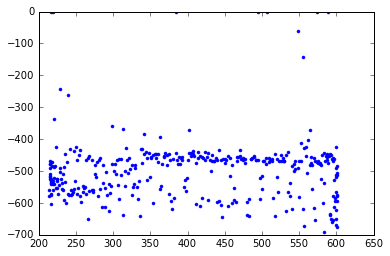

In [72]:
plt.plot(dfS['sunrise'].values, dfS['s_ed_md'].values, '.')

### Agregation by week number

In [73]:
dfSByWeekMean = dfS.groupby('week_number').mean()
dfSByWeekMax = dfS.groupby('week_number').max()
dfSByWeekMin = dfS.groupby('week_number').min()

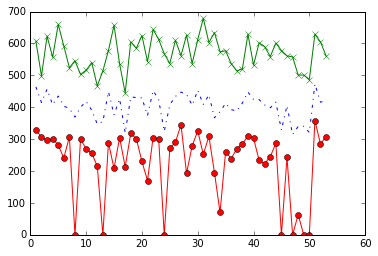

In [74]:
plt.plot(dfSByWeekMean.index.values, (dfSByWeekMean['s_deep']+dfSByWeekMean['s_lt']).values, '-.',
        dfSByWeekMax.index.values, (dfSByWeekMax['s_deep']+dfSByWeekMax['s_lt']).values, '-x',
        dfSByWeekMin.index.values, (dfSByWeekMin['s_deep']+dfSByWeekMin['s_lt']).values, '-o')

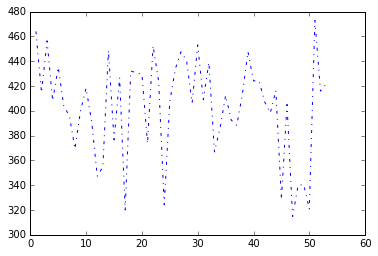

In [75]:
plt.plot(dfSByWeekMean.index.values, (dfSByWeekMean['s_deep']+dfSByWeekMean['s_lt']).values, '-.')

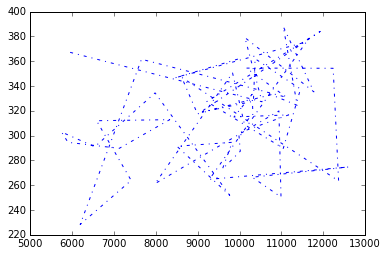

In [76]:
plt.plot(dfSByWeekMean['a_ttl'].values, dfSByWeekMean['s_lt'].values, '-.')

## Sleep on week day

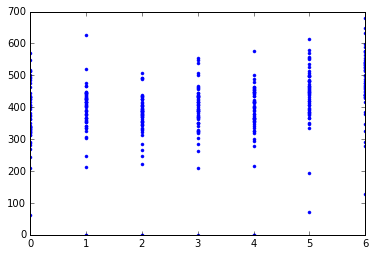

In [77]:
plt.plot(dfS['day'], (dfS['s_deep']+dfS['s_lt']).values, '.')

## Agregation by day number

In [78]:
dfSBydayMean = dfS.groupby('day').mean()
dfSBydayMax = dfS.groupby('day').max()
dfSBydayMin = dfS.groupby('day').min()

### Sleep vs day of week

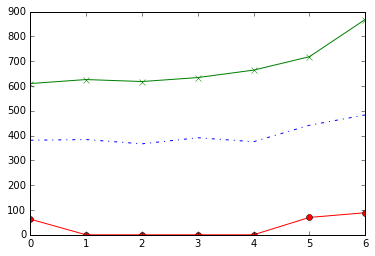

In [79]:
plt.plot(dfSBydayMean.index.values, (dfSBydayMean['s_deep']+dfSBydayMean['s_lt']).values, '-.',
        dfSBydayMax.index.values, (dfSBydayMax['s_deep']+dfSBydayMax['s_lt']).values, '-x',
        dfSBydayMin.index.values, (dfSBydayMin['s_deep']+dfSBydayMin['s_lt']).values, '-o')

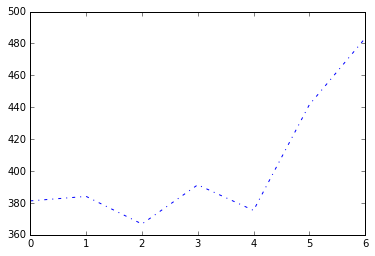

In [80]:
plt.plot(dfSBydayMean.index.values, (dfSBydayMean['s_deep']+dfSBydayMean['s_lt']).values, '-.')

### Activity vs day of week

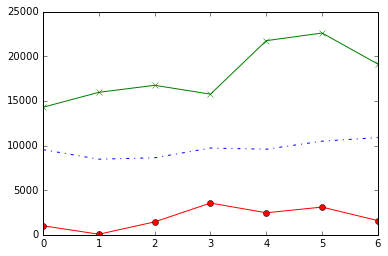

In [81]:
plt.plot(dfSBydayMean.index.values, dfSBydayMean['a_ttl'].values, '-.',
        dfSBydayMax.index.values, dfSBydayMax['a_ttl'].values, '-x',
        dfSBydayMin.index.values, dfSBydayMin['a_ttl'].values, '-o')

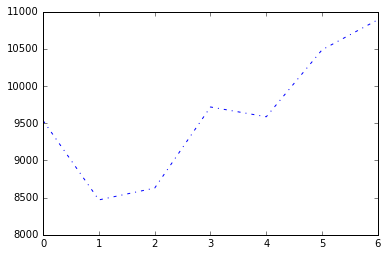

In [82]:
plt.plot(dfSBydayMean.index.values, dfSBydayMean['a_ttl'].values, '-.')

## Simple in-time period analyze

In [83]:
dfS['datetime'] = pd.to_datetime(dfS['DATE']);

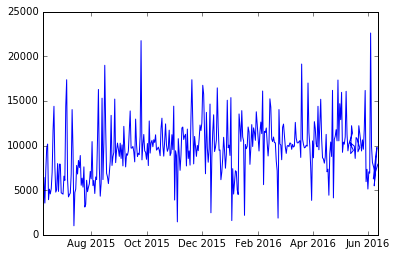

In [84]:
plt.plot(dfS['datetime'].values, dfS['a_ttl'].values)

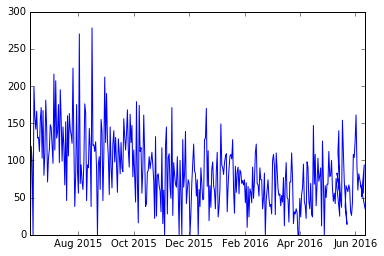

In [85]:
plt.plot(dfS['datetime'].values, dfS['s_deep'].values)

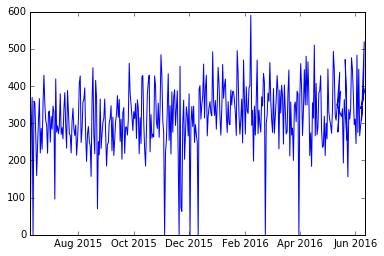

In [86]:
plt.plot(dfS['datetime'].values, dfS['s_lt'].values)

### Sleep ratio prediction with Linear regression

In [137]:
dfS.columns

Index([u's_usrEd', u's_lt', u's_st', u's_st_t', u's_wk', u's_deep', u's_usrSt',
       u's_ed', u's_ed_t', u'v', u'goal', u'a_rn', u'a_cal', u'a_runDist',
       u'a_wk', u'a_ttl', u'a_runCal', u'a_dis', u'DATE', u'date_timestamp',
       u's_st_md', u's_ed_md', u'day', u'week_number', u'sunset', u'sunrise',
       u'datetime'],
      dtype='object')

In [138]:
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import KFold

In [139]:
dfSML = dfS[(dfS['s_lt'] != 0) & (dfS['s_deep'] != 0)]


In [140]:
dfS.shape

(370, 27)

In [141]:
dfSML.shape

(358, 27)

In [142]:
X_columns = ['s_wk','a_ttl','s_st_md','s_ed_md']
Y_columns = 's_deep'

In [143]:
X = dfSML[X_columns]
y = dfSML['s_deep']/dfSML['s_lt']

In [144]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [145]:
clf = LinearRegression(normalize=True)

In [146]:
clf.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=True)

In [147]:
clf.coef_

array([ -6.18147991e-04,  -1.49517016e-05,   1.14277419e-04,
         3.24408507e-04])

In [148]:
y_pred = clf.predict(X_test)

In [149]:
scores = cross_val_score(LinearRegression(normalize=True), X_train, y_train,
                         cv=KFold(len(X_train), n_folds=5, shuffle=True, random_state=241))

In [154]:
scores.mean()

0.029740570384384712

## So, we have very very poor prediction - we can't predict sleep ratio

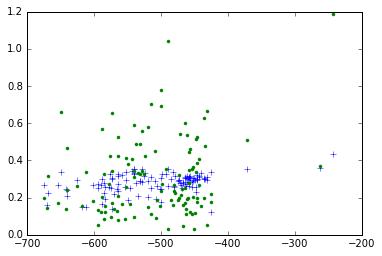

In [101]:
plt.plot(X_test['s_ed_md'].values,y_pred, '+',X_test['s_ed_md'].values, y_test, '.')

### Add extra columns and repeat prediction

In [102]:
dfS.columns

Index([u's_usrEd', u's_lt', u's_st', u's_st_t', u's_wk', u's_deep', u's_usrSt',
       u's_ed', u's_ed_t', u'v', u'goal', u'a_rn', u'a_cal', u'a_runDist',
       u'a_wk', u'a_ttl', u'a_runCal', u'a_dis', u'DATE', u'date_timestamp',
       u's_st_md', u's_ed_md', u'day', u'week_number', u'sunset', u'sunrise',
       u'datetime'],
      dtype='object')

In [103]:
X_columns = ['s_wk','a_ttl','s_st_md','s_ed_md','day', 'sunset', 'sunrise']

In [104]:
X = dfSML[X_columns]
y = dfSML['s_deep']/dfSML['s_lt']

In [105]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [106]:
scores = cross_val_score(LinearRegression(normalize=True), X_train, y_train,
                         cv=KFold(len(X_train), n_folds=5, shuffle=True, random_state=241))

In [107]:
scores.mean()

0.074145435774440702

## Litle bit better prediction, but also very very poor

In [108]:
clf2 = LinearRegression(normalize=True)

In [109]:
clf2.fit(X_train,y_train)
clf2.coef_

array([ -3.43945110e-04,  -1.20884185e-05,   6.93026745e-05,
         2.98507452e-04,   3.08179753e-04,  -8.69704317e-04,
        -1.15549849e-03])

In [110]:
y_pred2=clf2.predict(X_test)

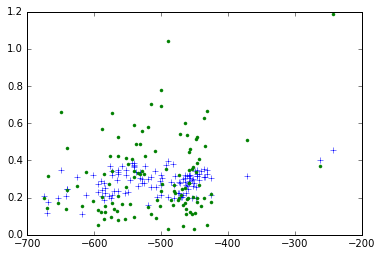

In [111]:
plt.plot(X_test['s_ed_md'].values,y_pred2, '+',X_test['s_ed_md'].values, y_test, '.')

### Add polynomial features

In [164]:
from sklearn.preprocessing import PolynomialFeatures

In [165]:
poly = PolynomialFeatures(2)
X2 = poly.fit_transform(X)

In [166]:
X_train, X_test, y_train, y_test = train_test_split(X2, y, test_size=0.33, random_state=42)

In [167]:
scores = cross_val_score(LinearRegression(normalize=True), X_train, y_train,
                         cv=KFold(len(X_train), n_folds=5, shuffle=True, random_state=241))
scores.mean()

-0.057244665573059447

### Overfitting?

In [172]:
X2.shape

(358, 15)

In [173]:
clf2.fit(X_train,y_train)
clf2.coef_

array([  0.00000000e+00,  -4.67783493e-03,  -6.28862139e-05,
        -2.43122156e-03,   1.12111578e-03,   8.82524171e-06,
         2.48580745e-07,   8.51519617e-06,  -2.12071965e-06,
         1.33303895e-09,   1.32990282e-07,  -6.05113095e-08,
         1.18227833e-06,  -2.91372066e-06,   4.73861828e-07])

In [174]:
y_pred2=clf2.predict(X_test)

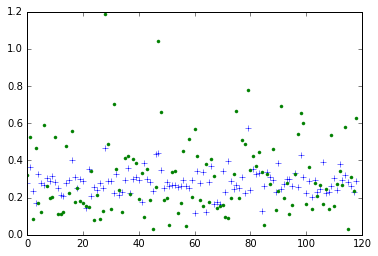

In [175]:
plt.plot(range(len(y_pred2)),y_pred2, '+',range(len(y_pred2)), y_test, '.')

## 4. Analyze RAW data

In [176]:
dfRawRed['pulse'].mean()

nan

In [177]:
dfRawRed.head()

,timestamp,activity1,activity2,activity3,pulse,a1d,a2d,a3d,day,week_number,hour,DOfW
2016-04-01 00:01:00+03:00,1459458060,16,92,2,NaN,15,24,2,3,13,0,4
2016-04-01 00:02:00+03:00,1459458120,0,90,15,NaN,-16,-2,13,3,13,0,4
2016-04-01 00:03:00+03:00,1459458180,1,93,21,NaN,1,3,6,3,13,0,4
2016-04-01 00:04:00+03:00,1459458240,1,87,52,NaN,0,-6,31,3,13,0,4
2016-04-01 00:05:00+03:00,1459458300,0,93,15,NaN,-1,6,-37,3,13,0,4


### Add diff

In [178]:
dfRawRed['a1d']=dfRawRed['activity1'].diff()
dfRawRed['a2d']=dfRawRed['activity2'].diff()
dfRawRed['a3d']=dfRawRed['activity3'].diff()
dfRawRed = dfRawRed.dropna(subset=['a1d','a2d','a3d'])

In [216]:
dfRawRed['day'] = pd.to_datetime(dfRawRed.index, unit='s').dayofyear
dfRawRed['week_number'] =  pd.to_datetime(dfRawRed.index, unit='s').week
dfRawRed['hour'] =  pd.to_datetime(dfRawRed.index, unit='s').hour
dfRawRed['DOfW'] =  pd.to_datetime(dfRawRed.index, unit='s').dayofweek

### Hours aggregation

In [217]:
dfRawRed.activity1 = dfRawRed.activity1.astype(np.float64)
dfRawRed.activity2 = dfRawRed.activity2.astype(np.float64) 
dfRawRed.activity3 = dfRawRed.activity3.astype(np.float64)
dfRawRed.pulse = dfRawRed.pulse.astype(np.float64) 

In [236]:
dfRawRed.head()

,timestamp,activity1,activity2,activity3,pulse,a1d,a2d,a3d,day,week_number,hour,DOfW
2016-04-01 00:02:00+03:00,1459458120,0,90,15,NaN,-16,-2,13,92,13,0,4
2016-04-01 00:03:00+03:00,1459458180,1,93,21,NaN,1,3,6,92,13,0,4
2016-04-01 00:04:00+03:00,1459458240,1,87,52,NaN,0,-6,31,92,13,0,4
2016-04-01 00:05:00+03:00,1459458300,0,93,15,NaN,-1,6,-37,92,13,0,4
2016-04-01 00:06:00+03:00,1459458360,1,73,17,NaN,1,-20,2,92,13,0,4


In [219]:
dfRawByHourMean = dfRawRed.groupby('hour').mean()
dfRawByHourMax = dfRawRed.groupby('hour').max()
dfRawByHourMin = dfRawRed.groupby('hour').min()
dfRawByHourSum = dfRawRed.groupby('hour').sum()
dfRawByHourStd = dfRawRed.groupby('hour').std()

In [220]:
dfRawByHourMean.head()

,activity1,activity2,activity3,pulse,a1d,a2d,a3d,day,week_number,DOfW
hour,,,,,,,,,,
0,1.392188,18.805391,1.767931,NaN,-0.231841,-0.089082,0.013248,128.016446,18.276382,3.081772
1,1.983790,14.585388,1.339041,NaN,0.007763,-0.125114,-0.036073,128.000000,18.273973,3.082192
2,2.995205,8.143607,0.474429,NaN,0.015297,-0.063927,-0.009132,128.000000,18.273973,3.082192
3,3.825342,5.372146,0.081279,NaN,0.007991,-0.043607,0.000000,128.000000,18.273973,3.082192
4,4.071461,5.414840,0.056849,NaN,-0.002283,0.044977,0.000000,128.000000,18.273973,3.082192


### Mean/Max/Min steps agregated hour column

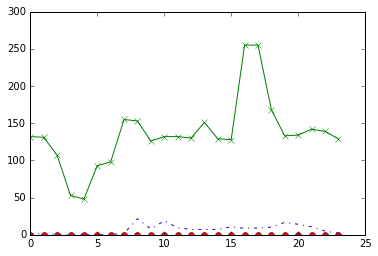

In [221]:
plt.plot(dfRawByHourMean.index.values, dfRawByHourMean['activity3'].values, '-.',label='steps mean (3th byte raw data)')
plt.plot(dfRawByHourMax.index.values, dfRawByHourMax['activity3'].values, '-x',label='steps max (3th byte raw data)')
plt.plot(dfRawByHourMin.index.values, dfRawByHourMin['activity3'].values, '-o',label='steps hour (3th byte raw data)')
#plt.legend(loc='upper left', shadow=True)

### Steps and scaled differential

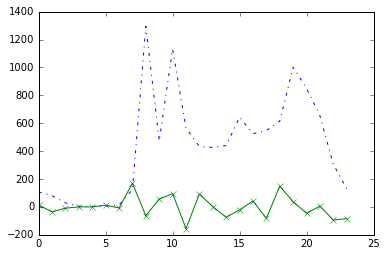

In [222]:
plt.plot(dfRawByHourMean.index.values, dfRawByHourMean['activity3'].values*60, '-.',
        dfRawByHourMean.index.values, dfRawByHourMean['a3d'].values*1000, '-x')

### Sleep and scaled differential

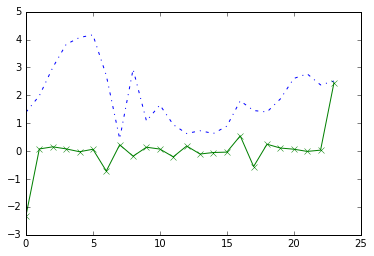

In [223]:
plt.plot(dfRawByHourMean.index.values, dfRawByHourMean['activity1'].values, '-.',
        dfRawByHourMean.index.values, dfRawByHourMean['a1d'].values*10, '-x')

### Second byte and differential

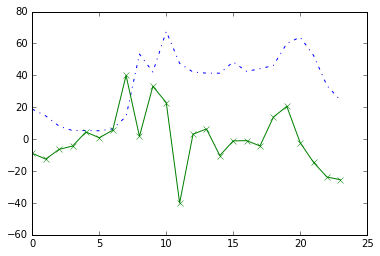

In [224]:
plt.plot(dfRawByHourMean.index.values, dfRawByHourMean['activity2'].values, '-.',
        dfRawByHourMean.index.values, dfRawByHourMean['a2d'].values*100, '-x')

### Activity +- Std

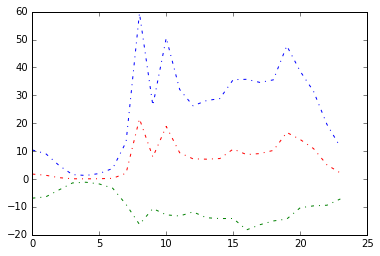

In [225]:
plt.plot(dfRawByHourStd.index.values, dfRawByHourMean['activity3'].values+dfRawByHourStd['activity3'].values, '-.',
        dfRawByHourStd.index.values, dfRawByHourMean['activity3'].values-dfRawByHourStd['activity3'].values,'-.',
        dfRawByHourStd.index.values, dfRawByHourMean['activity3'].values,'-.')

### Sleep +- Std

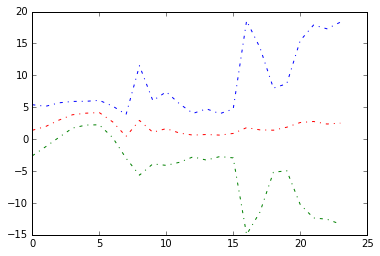

In [226]:
plt.plot(dfRawByHourStd.index.values, dfRawByHourMean['activity1'].values+dfRawByHourStd['activity1'].values, '-.',
        dfRawByHourStd.index.values, dfRawByHourMean['activity1'].values-dfRawByHourStd['activity1'].values,'-.',
        dfRawByHourStd.index.values, dfRawByHourMean['activity1'].values,'-.')

### Sleep/2d byte/Activity on same figure vs hours

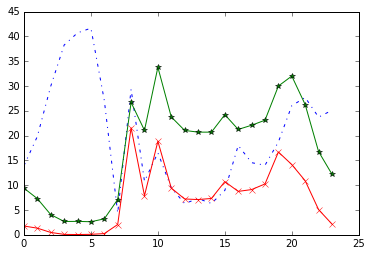

In [228]:
plt.plot(dfRawByHourStd.index.values, dfRawByHourMean['activity1'].values*10, '-.',
        dfRawByHourStd.index.values, dfRawByHourMean['activity2'].values/2,'-*',
        dfRawByHourStd.index.values, dfRawByHourMean['activity3'].values,'-x',
        dfRawByHourStd.index.values, dfRawByHourMean['pulse'].values/10,'-')

### Day of year aggregation

In [239]:
dfRawByDayMean = dfRawRed.groupby('day').mean()
dfRawByDayMax = dfRawRed.groupby('day').max()
dfRawByDayMin = dfRawRed.groupby('day').min()
dfRawByDaySum = dfRawRed.groupby('day').sum()
dfRawByDayStd = dfRawRed.groupby('day').std()

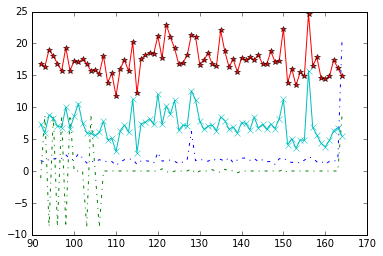

In [240]:
plt.plot(dfRawByDayStd.index.values, dfRawByDayMean['activity1'].values, '-.',
         dfRawByDayStd.index.values, dfRawByDayMean['a1d'].values*100, '-.',
        dfRawByDayStd.index.values, dfRawByDayMean['activity2'].values/2,'-*',
        dfRawByDayStd.index.values, dfRawByDayMean['activity3'].values,'-x',
        dfRawByDayStd.index.values, dfRawByDayMean['pulse'].values/10,'-')

### Week number aggregation

In [243]:
dfRawByWeekMean = dfRawRed.groupby('week_number').mean()
dfRawByWeekMax = dfRawRed.groupby('week_number').max()
dfRawByWeekMin = dfRawRed.groupby('week_number').min()
dfRawByWeekSum = dfRawRed.groupby('week_number').sum()
dfRawByWeekStd = dfRawRed.groupby('week_number').std()

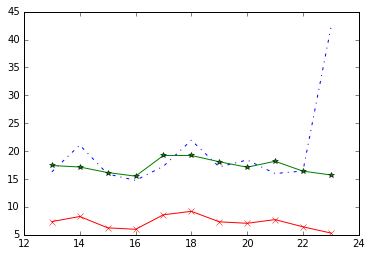

In [244]:
plt.plot(dfRawByWeekStd.index.values, dfRawByWeekMean['activity1'].values*10, '-.',
        dfRawByWeekStd.index.values, dfRawByWeekMean['activity2'].values/2,'-*',
        dfRawByWeekStd.index.values, dfRawByWeekMean['activity3'].values,'-x',
        dfRawByWeekStd.index.values, dfRawByWeekMean['pulse'].values/10,'-')

### Day of week aggregation

In [213]:
dfRawByDOfWMean = dfRawRed.groupby('DOfW').mean()
dfRawByDOfWMax = dfRawRed.groupby('DOfW').max()
dfRawByDOfWMin = dfRawRed.groupby('DOfW').min()
dfRawByDOfWSum = dfRawRed.groupby('DOfW').sum()
dfRawByDOfWStd = dfRawRed.groupby('DOfW').std()

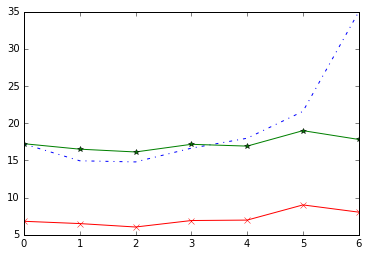

In [214]:
plt.plot(dfRawByDOfWStd.index.values, dfRawByDOfWMean['activity1'].values*10, '-.',
        dfRawByDOfWStd.index.values, dfRawByDOfWMean['activity2'].values/2,'-*',
        dfRawByDOfWStd.index.values, dfRawByDOfWMean['activity3'].values,'-x',
        dfRawByDOfWStd.index.values, dfRawByDOfWMean['pulse'].values/10,'-')

## Cluster Analysis

In [245]:
from sklearn.cluster import KMeans

In [246]:
dfRawRed.head()

,timestamp,activity1,activity2,activity3,pulse,a1d,a2d,a3d,day,week_number,hour,DOfW
2016-04-01 00:02:00+03:00,1459458120,0,90,15,NaN,-16,-2,13,92,13,0,4
2016-04-01 00:03:00+03:00,1459458180,1,93,21,NaN,1,3,6,92,13,0,4
2016-04-01 00:04:00+03:00,1459458240,1,87,52,NaN,0,-6,31,92,13,0,4
2016-04-01 00:05:00+03:00,1459458300,0,93,15,NaN,-1,6,-37,92,13,0,4
2016-04-01 00:06:00+03:00,1459458360,1,73,17,NaN,1,-20,2,92,13,0,4


In [249]:
y_pred = KMeans(n_clusters=4, random_state=241).fit_predict(dfRawByHourMean[['activity1','a1d','a2d','a3d','activity3','activity2']])

In [250]:
y_pred

array([1, 1, 3, 3, 3, 3, 3, 1, 0, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 2, 2,
       1], dtype=int32)

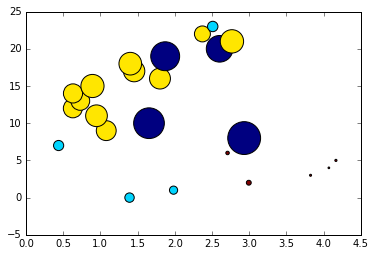

In [251]:
plt.scatter(dfRawByHourMean['activity1'].values,dfRawByHourMean.index.values, c = y_pred,s = 50*dfRawByHourMean['activity3'].values) #s = dfRawRed['activity1'].values